In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date

'2017-08-23'

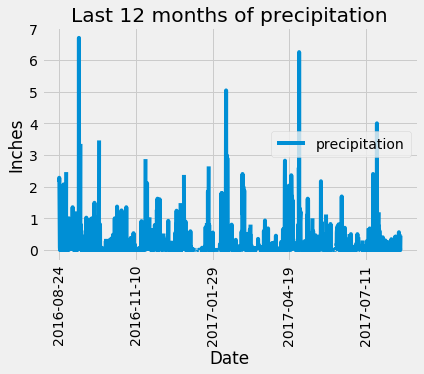

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date


# Calculate the date one year from the last date in data set.
most_recent_datetime = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_datetime - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

perc_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(perc_data, columns=['date', 'precipitation'])


# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date')


# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x='date', y='precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Last 12 months of precipitation')
plt.show()


#Text(0, 0.5, 'Inches')

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data

prcp_stats = prcp_df.describe()
prcp_stats

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).one()[0]


9

In [22]:
from sqlalchemy import desc

# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(desc(func.count(Measurement.station)))\
                        .all()
for station in station_counts:
    print(station[0],station[1])


USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station, 
                                    func.min(Measurement.tobs), 
                                    func.max(Measurement.tobs), 
                                    func.avg(Measurement.tobs))\
                             .filter(Measurement.station == station_counts[0][0])\
                             .all()
most_active_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

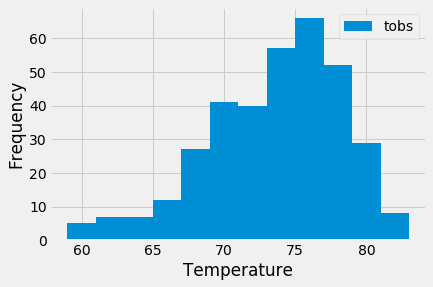

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).\
    first()[0]

temp_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == most_active_station).\
    all()

# Save the query results as a Pandas DataFrame
temp_df = pd.DataFrame(temp_data, columns=['temperature'])

# Plot the results as a histogram
temp_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(["tobs"])

plt.show()

#text(0.5, 4.183333333333314, 'Temperature')

# Close Session

In [25]:
# Close Session
session.close()